# 6 - Advanced simulations of a 2D Ising model

# 6.1 Exercise: Wolff cluster algorithm

I've implemented the Wolff cluster algorithm to simulate a 2D Ising model under periodic boundary conditions. This implementation is an adaptation of the previous Glauber step algorithm. However, the main difference lies in how the spins' configurations are updated. 

In the Metropolis Glauber algorithm, I employed single spin flip dynamics. Conversely, with Wolff, I utilized cluster spin flip dynamics. At each time step, I construct a cluster of spins starting from a randomly chosen seed, and then proceed to flip all spins within this cluster. 

The advantage of the Wolff algorithm is its ability to circumvent the critical slowing down problem encountered in traditional methods.


#### Overview of the MC algorithm 

In this study, we will employ the Wolff algorithm to generate a set of configurations for the Ising model. Given an initial configuration, the following steps are used to generate the next configuration:

1. Starting from a random spin, build the cluster of spins;

2. Flip the cluster of spins $s^C={s^C_1, s^C_2,.., s^C_c}$ on the lattice: $s_{i,j} \rightarrow -s_{i,j} \quad \forall s_{i,j} \in s^C $. This action results in a new set of spins $S' = \{s_{1,1}, s_{1,2}, \ldots, s_{i,j}, \ldots, s_{L,L}\}$.

3. Calculate the change in energy, $\delta E = E(S') - E(S)$.

4. Accept $S'$ as the new configuration with a probability determined by:
$W(s_{i,j} \rightarrow -s_{i,j}) =
\begin{cases}
1, & \text{if }\delta E \leq 0 \\
e^{-\beta \delta E}, & \text{otherwise}
\end{cases}$


If $S'$ is rejected, the current configuration $S$ remains unchanged.
A full update involves repeating these steps $L^2$ times. The next configuration in the set used for the Monte Carlo method is obtained after one full update. 
The previous configuration is utilized as the starting configuration for the next update. 

It's important to note that the configurations generated using this algorithm are not independent since each new configuration is derived from the previous one.


#### Cluster of spin construction
The probability of performing the move from state $i$ to state $j$ is given by:
$$
p_{i,j} = \Gamma_{i,j}a_{i,j}
$$
where $\Gamma_{i,j}$ is the proposal and $a_{i,j}$ is the acceptance probability. 

 By construction, the spins within the cluster $\mathcal C$ are all aligned, so the only difference occurs at the boundary of $\mathcal C$. Let $m + n$ be the length of the boundary of $\mathcal C$, where $m$ is the number of edges separating aligned sites and $n$ the number of edges separating anti-aligned sites. The probability of the cluster being selected is proportional to:
 $$
  \Gamma_{i,j} \sim (1-p_{add})^m
 $$

 because for each of the $m$ edges there was an independent chance for the neighbor not to be added. For the state $s'$ (after the cluster flip) the roles of $m$ and $n$ are exactly interchanged, so there the probability is proportional to 

 $$
  \Gamma_{j,i} \sim (1-p_{add})^n
 $$

The detailed balance condition reads:
$$
\frac{p_{i,j}}{p_{j,i}} = \frac{\Gamma_{i,j}a_{i,j}}{\Gamma_{j,i}a_{j,i}} = (1-p_{add})^{m-n} \frac{a_{i,j}}{a_{j,i}} =  e^{-\beta \Delta E_{i,j}}
$$

The ratio of acceptance can be made equal to one by imposing:
$$
p_{add} = 1 - e^{-2\beta J}
$$

The pseudocode for a move of the Wolff algorithm is:

1. Initialization: pick a spin, $S_i$ , at random as the first spin in the cluster;


2. Cluster Growth: Starting from the seed spin, grow the cluster by iteratively adding neighboring spins with the same orientation (i.e., spins aligned with the seed spin's orientation) with probability defined as $1 - e^{-2\beta J}$, where $\beta$ is the inverse temperature and $J$ is the coupling constant (J=1).


3. repeat 2. with the newly added spins until no new spins are added to the cluster;


4. Spin flip: flip all the spins in the cluster to their opposite value.

#### Periodic boundary conditions

As reported also in the previous implementation of the ising model, in this code I implemented periodic boundary conditions (PBC) for the spin matrix. <br>
The use of PBC ensures that the two-dimensional space is effectively wrapped around, creating a toroidal topology. This toroidal mapping of the space is a useful approach in simulating systems with PBC, as it emulates the behavior of an infinite system while working with a finite representation. <br>

In practice, if $(i,j)$ is the location of a spin in the matrix, the nearest neighbours will be identified using this notation:<br> 
    ```` nn_left = ((i - 1 + nx) % nx) + j * nx; ```` <br>
	````nn_right = ((i + 1) % nx) + j * nx;````<br>
	````nn_up = i + ((j + 1) % ny) * nx;````<br>
	````nn_down = i + ((j - 1 + ny) % ny) * nx;````<br>
Notice that the mapping function from the coordinates (row, column) $(i, j)$ in the matrix to the single index identifier in the spins array of dimension $n_x \cdot n_y$ is as follows:
$$
(i, j) \longrightarrow j + i\cdot n_x
$$
It follows that the $\textbf{spin matrix}$ is a $\textbf{1-d}$ vector of lenght $nx \times ny$.


### Example of Cluster-Flip

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
state = np.loadtxt('Wolff/cluster_test1.txt')
state_flipped = np.loadtxt('Wolff/cluster_test2.txt')
state = state.reshape((10,10))
state_flipped = state_flipped.reshape((10,10))


# cluster elements
clusters_elements = np.array([2, 3, 12, 93, 94])
row_indices, col_indices = np.unravel_index(clusters_elements, state.shape)

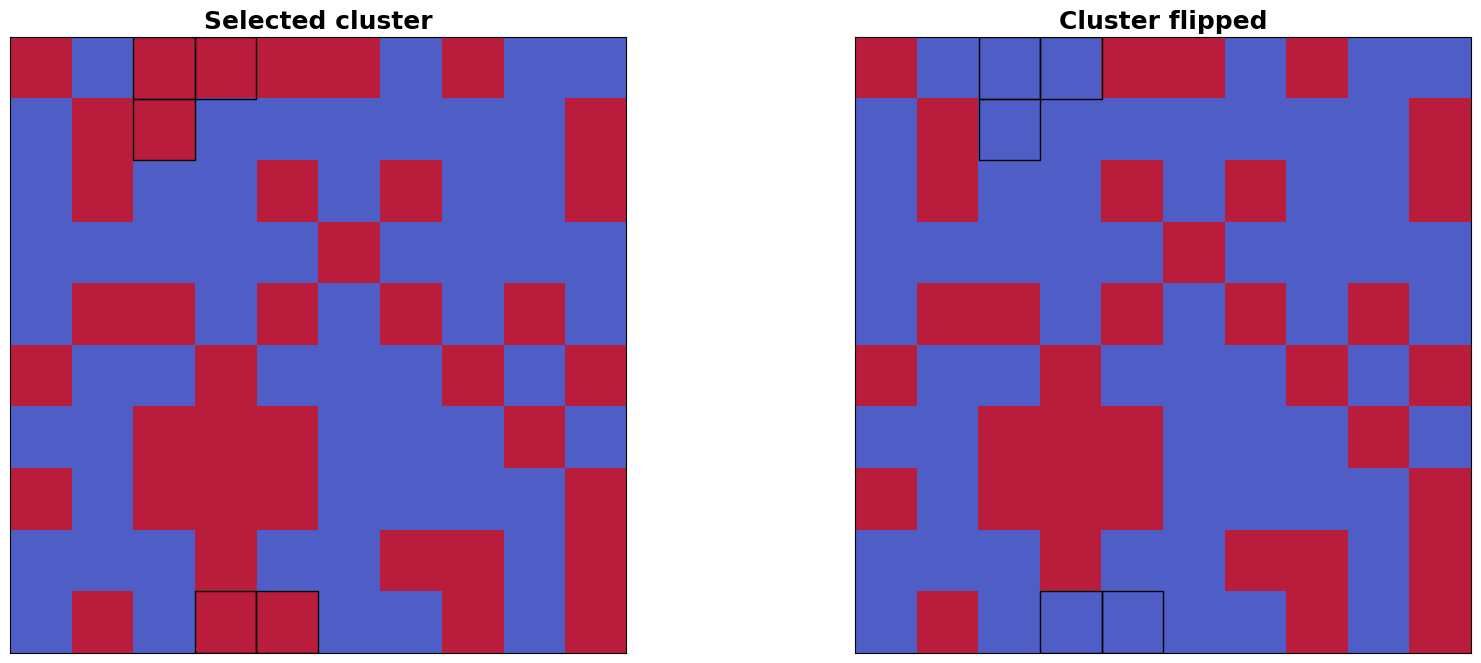

In [3]:
# Plotting
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(20,8))
ax1.matshow(state, cmap = plt.cm.coolwarm , alpha = 0.9)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("Selected cluster", fontsize = 18, fontweight = "bold")
ax2.matshow(state_flipped, cmap = plt.cm.coolwarm, alpha =  0.9)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title("Cluster flipped", fontsize = 18, fontweight = "bold")

# Highlighting elements in clusters_elements
for row, col in zip(row_indices, col_indices):
    ax1.add_patch(plt.Rectangle((col - 0.5, row - 0.5), 1, 1, fill=False, color = 'black'))
    ax2.add_patch(plt.Rectangle((col - 0.5, row - 0.5), 1, 1, fill=False, color = 'black'))


### Exemple of energy and magnetization with Wolff

| Parameters                        |                                 |
|-----------------------------------|---------------------------------|
| L                                 |   50                            |
| J                                 |   1                             |
| $k_BT$                            |   1.5$ T_c$                        |
| $N_{steps}$                       |   10^4                          |
| $N_{realiz}$                      |   1                             |
| Initialization of spins            |   rnd                           |


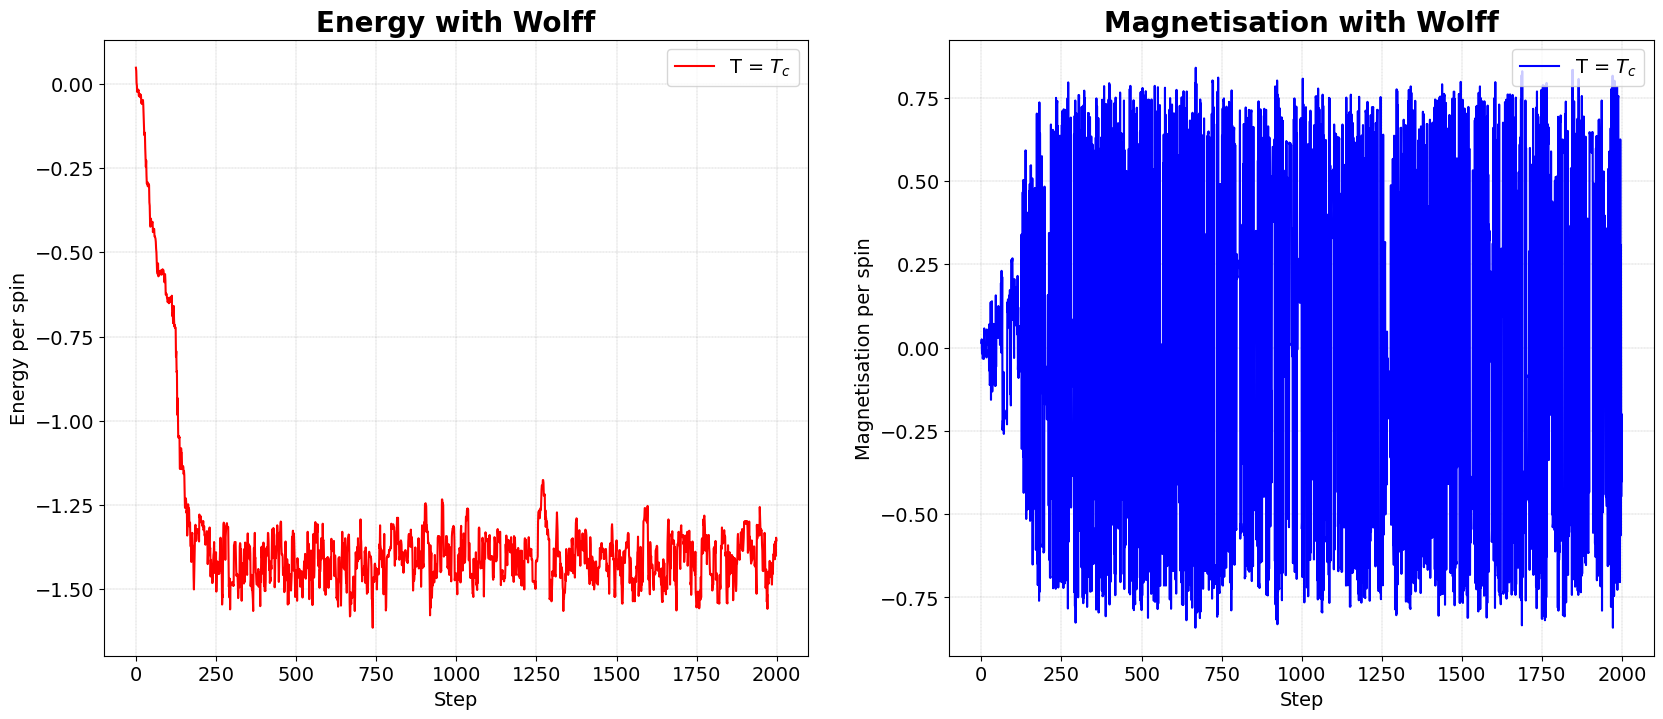

In [4]:
data = np.loadtxt('Wolff/wolff_test2.txt')[:2000]
x = data[:,0]
E = data[:,1]
M = data[:,2]

fig, (ax0, ax1) = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8))
ax0.plot(E , 'red', label = r'T = $T_c$')
ax0.set_title('Energy with Wolff', fontsize = 20, fontweight = "bold")
ax0.set_xlabel('Step', fontsize=14)
ax0.set_ylabel('Energy per spin', fontsize=14)
ax0.tick_params(axis="x",labelsize=14)
ax0.tick_params(axis="y",labelsize=14)
ax0.legend(loc='upper right', fontsize=14)
ax0.grid(linestyle = '--', linewidth = 0.2, color='grey')

ax1.plot(M , 'blue', label = r'T = $T_c$')
ax1.set_title('Magnetisation with Wolff', fontsize = 20, fontweight = "bold")
ax1.set_xlabel('Step', fontsize=14)
ax1.set_ylabel('Magnetisation per spin', fontsize=14)
ax1.tick_params(axis="x",labelsize=14)
ax1.tick_params(axis="y",labelsize=14)
ax1.legend(loc='upper right', fontsize=14)
ax1.grid(linestyle = '--', linewidth = 0.2, color='grey')

## Cluster size statistics
By assuming $k_B= 1$ and $J= 1$, simulate the 2D Ising model $(L=50)$ for different temperatures: the critical temperature $T_c=\frac2{\ln(1+\sqrt2)}$, a high temperature $T_h=2T_c$ and a low temperaturee $T_l=T_c/2$. Collect thelcluster sizes of the Wolff algorithm and plot their histograms for the three temperatures. What can one note?



In [5]:
# Function to find and annotate labels above histogram maxima
def annotate_maxima(hist, label):
    if label == 'Tc':
        max_index = np.argmax(hist[5:])
    else:
        max_index = np.argmax(hist)
    max_value = hist[max_index]
    bin_center = bins[max_index] + (bins[1] - bins[0]) / 2
    plt.annotate(f"{label}", xy=(bin_center, max_value),
                 xytext=(bin_center + 5, max_value + 2),  # Adjust offset for better placement
                 ha='center', va='bottom', fontsize=8)


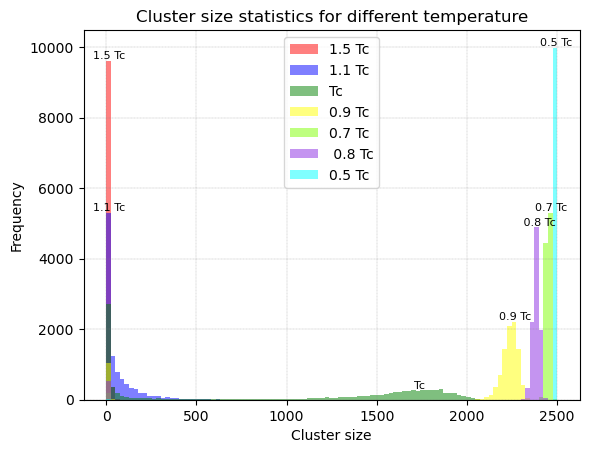

In [6]:
# load the data for the histograms
data = [np.array(np.loadtxt('Wolff/wolff_test_1.5.txt'))[:,3],
        np.array(np.loadtxt('Wolff/wolff_test_1.1.txt'))[:,3],
        np.array(np.loadtxt('Wolff/wolff_test_1.0.txt'))[:,3],
        np.array(np.loadtxt('Wolff/wolff_test_0.9.txt'))[:,3],
        np.array(np.loadtxt('Wolff/wolff_test_0.7.txt'))[:,3],
        np.array(np.loadtxt('Wolff/wolff_test_0.8.txt'))[:,3],
        np.array(np.loadtxt('Wolff/wolff_test_0.5.txt'))[:,3]]

labels = ["1.5 Tc", "1.1 Tc", "Tc", "0.9 Tc",  "0.7 Tc", " 0.8 Tc", "0.5 Tc"]
colors = np.array(["red", "blue", "green", "yellow", "chartreuse", "BlueViolet", "cyan"])
bins = np.linspace(0,50*50, 100)

# Plot the histograms
plt.figure()
plt.title("Cluster size statistics for different temperature")
plt.xlabel("Cluster size")
plt.ylabel("Frequency")

for i in range(len(data)):
    counts,_,_ = plt.hist(data[i], bins=bins, label=labels[i], alpha=0.5, color=colors[i])
    annotate_maxima(counts, labels[i])
    
plt.legend(loc = 'upper center')
plt.grid(linestyle = '--', linewidth = 0.2, color='grey')
plt.show()


In simulations involving Ising models with cluster flip dynamics at **low temperatures**, large clusters containing a significant portion of the total spins ($N = nx \times ny$) dominate the distribution. Here, the standard Wolff algorithm becomes inefficient, primarily causing minor fluctuations in the spin configuration. Conversely, at **very high temperatures**, the Wolff algorithm only generates very small clusters, making it functionally similar to simpler local algorithms like Metropolis. The most interesting behavior regarding cluster size distribution is observed near critical points, where the distribution exhibits a significant broadening.

## Autocorrelation time

For some values of $L$, compute the autocorrelation time $\tau$ at $T_\mathrm{c}$ of the magnetization time series for 
 - a) the single-spin flip algorithm, and 
 - b) the Wolff algorithm. 
 <br>
 Plot them in log-log scale vs $L$. Do they scale with $L$ as expected?

| Parameters Wolff                  |                                 |
|-----------------------------------|---------------------------------|
| L                                 |   [50, 80, 100, 120]            |
| J                                 |   1                             |
| $k_BT$                            |   $ T_c$                        |
| $N_{steps}$                       |    10^3                        |
| $N_{skip}$                      |   10^3                             |

| Parameters Glauber                |                                 |
|-----------------------------------|---------------------------------|
| L                                 |   [50, 80, 100, 120]            |
| J                                 |   1                             |
| $k_BT$                            |   $ T_c$                        |
| $N_{steps}$                       |    10^4                         |
| $N_{skip}$                        |   10^4                          |

In [7]:
from statsmodels.tsa.stattools import acf, pacf

# Load the data of the magnetization

M_cluster = [np.array(np.loadtxt('Wolff/wolff_50_Tc.txt'))[:,2],
        np.array(np.loadtxt('Wolff/wolff_80_Tc.txt'))[:,2],
        np.array(np.loadtxt('Wolff/wolff_100_Tc.txt'))[:,2],
        np.array(np.loadtxt('Wolff/wolff_120_Tc.txt'))[:,2]]

M_single = [np.array(np.loadtxt('Wolff/glauber_50_Tc.txt'))[:,2],
        np.array(np.loadtxt('Wolff/glauber_80_Tc.txt'))[:,2],
        np.array(np.loadtxt('Wolff/glauber_100_Tc.txt'))[:,2],
        np.array(np.loadtxt('Wolff/glauber_120_Tc.txt'))[:,2]]

# Load data of cluster sizes of the Wolff algorithm

M_cluster_size = [np.array(np.loadtxt('Wolff/wolff_50_Tc.txt'))[:,3],
        np.array(np.loadtxt('Wolff/wolff_80_Tc.txt'))[:,3],
        np.array(np.loadtxt('Wolff/wolff_100_Tc.txt'))[:,3],
        np.array(np.loadtxt('Wolff/wolff_120_Tc.txt'))[:,3]]
S = np.mean(M_cluster_size, axis=1) # average cluster size for each Lenght

lengths = np.array([50,80,100,120])

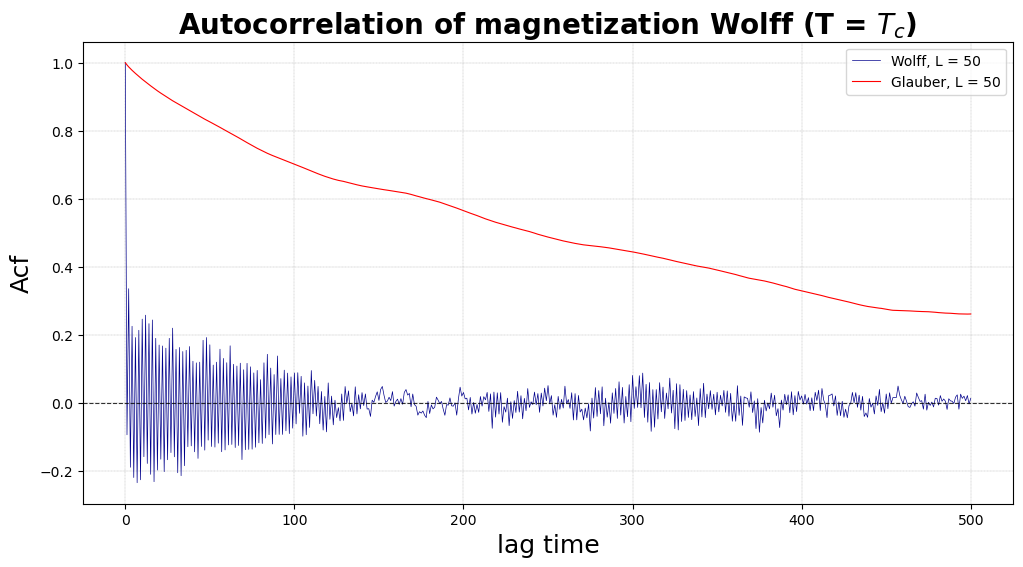

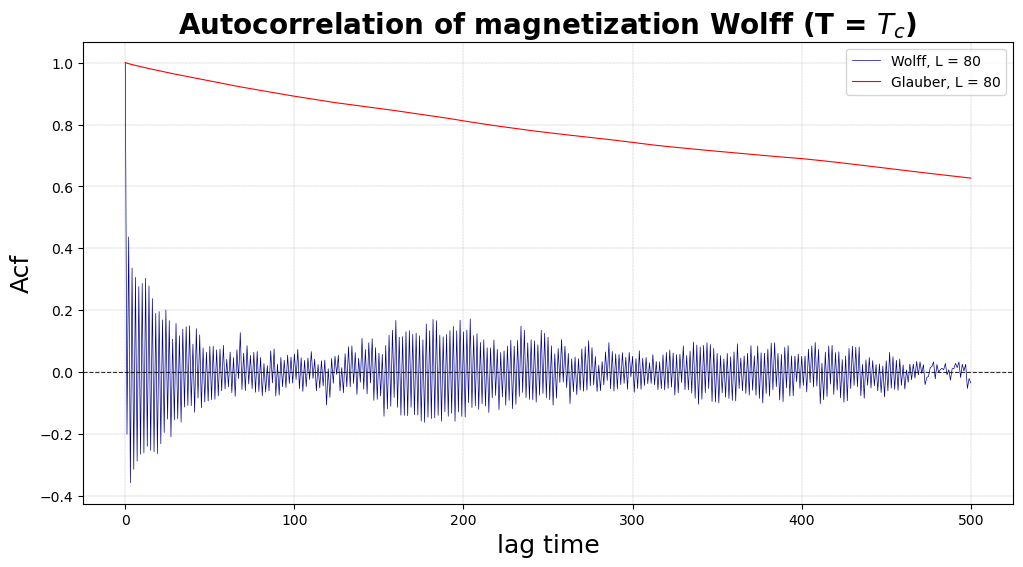

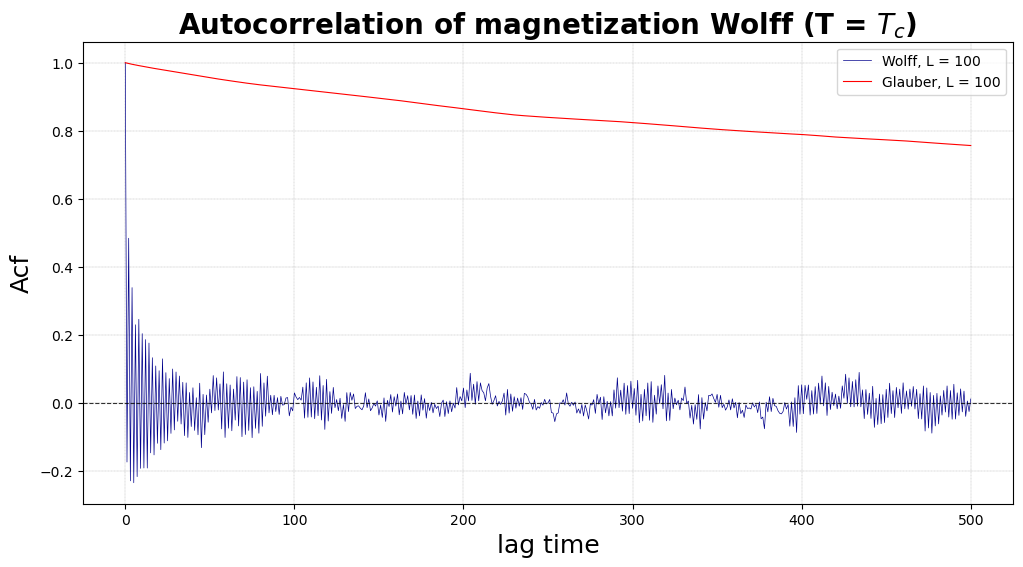

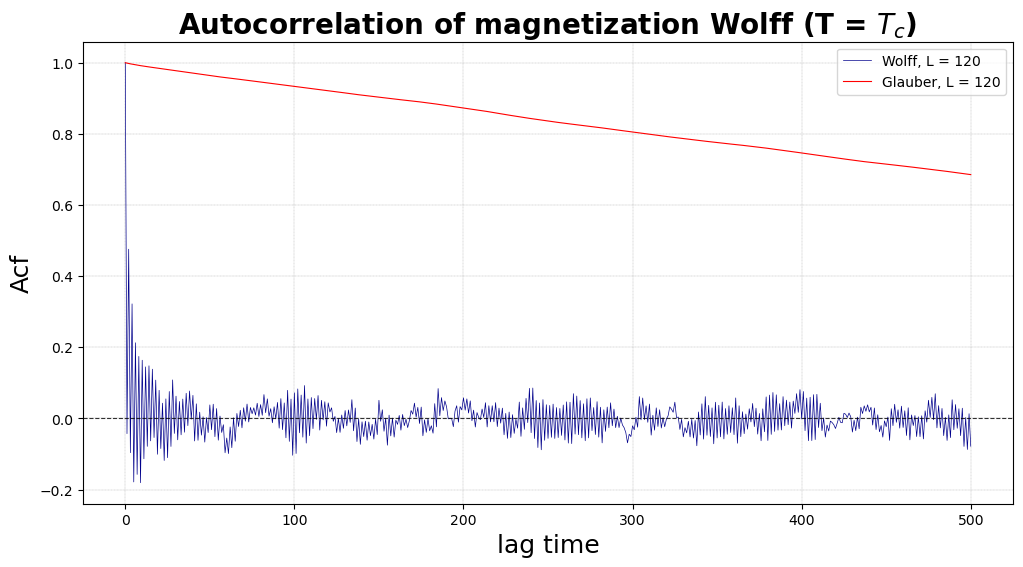

In [8]:
# Compute and plot the autocorrelation function of M

corr_MG = []
corr_MW = []
for i in range(len(M_cluster)):
    plt.figure(figsize=(12,6))
    tmpW = acf(M_cluster[i][:], nlags=500, fft = False) 
    tmpG = acf(M_single[i][:], nlags=500, fft = False) 
    corr_MG.append(tmpG)
    corr_MW.append(tmpW)
    plt.plot(tmpW, label=f'Wolff, L = {lengths[i]}', color='darkblue', linewidth=0.5)
    plt.plot(tmpG, label=f'Glauber, L = {lengths[i]}', color='red',linewidth=0.8)
    plt.title(r'Autocorrelation of magnetization Wolff (T = $T_c$)', fontsize=20, fontweight = "bold")
    plt.xlabel('lag time', fontsize=18)
    plt.ylabel('Acf', fontsize=18)
    plt.axhline(0, c = "black", linestyle = "--", linewidth = 0.8, alpha = 0.8)
    #plt.xlim([-10,200])
    plt.grid(linestyle = '--', linewidth = 0.2, color='grey')
    plt.legend()
    plt.show()


In [9]:
# compue the integrated autocorrelation time (method 2 in slides)
tau_list_MW = []
tau_list_MG = []
for i in range(4):
    tau_list_MW.append(np.sum(corr_MW[i]/corr_MW[i][0]))
    tau_list_MG.append(np.sum(corr_MG[i]/corr_MG[i][0]))
    
# in the case of cluster dynamics, rescale the tau by S/L^2
tau_list_MW = tau_list_MW*np.array(S)/np.array(lengths)**2

Let us show the plot of autocorrelation functions for both Wolff and Single spin glip algorithms at the critical temperature.

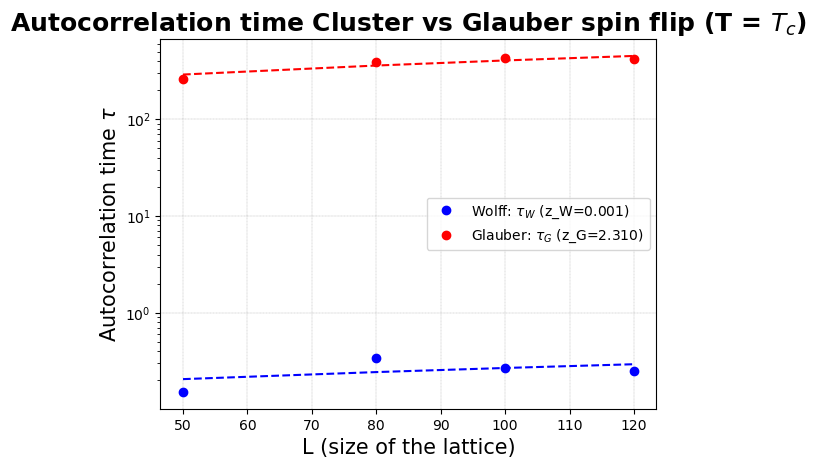

In [10]:
# Fit (tau vs L) straight line using linear regression
fit_MW = np.polyfit(lengths, tau_list_MW, 1)
fit_MG = np.polyfit(lengths, tau_list_MG, 1)

# Get the slopes (angular coefficients)
slope_MW = fit_MW[0]
slope_MG = fit_MG[0]

# Plot the data points and the fitted lines
plt.plot(lengths, tau_list_MW, 'bo', label=f'Wolff: $\\tau_W$ (z_W={slope_MW:.3f})')
plt.plot(lengths, tau_list_MG, 'ro', label=f'Glauber: $\\tau_G$ (z_G={slope_MG:.3f})')
plt.plot(lengths, np.polyval(fit_MW, lengths), 'b--')
plt.plot(lengths, np.polyval(fit_MG, lengths), 'r--')
plt.yscale('log')
plt.title(r'Autocorrelation time Cluster vs Glauber spin flip (T = $T_c$)', fontsize=18, fontweight='bold')
plt.xlabel('L (size of the lattice)', fontsize=15)
plt.ylabel(r'Autocorrelation time $\tau$', fontsize=15)
plt.grid(linestyle='--', linewidth=0.2, color='grey')
plt.legend()
plt.show()


In [11]:
lengths = [50, 80, 100, 120]
print('\nThe values of τ for each lattice size L for single spin flip is: \n')
for length, tau in zip(lengths, tau_list_MG):
    print(f"Length {length}: τ = {tau:.3f}")


The values of τ for each lattice size L for single spin flip is: 

Length 50: τ = 263.388
Length 80: τ = 395.073
Length 100: τ = 428.139
Length 120: τ = 420.548


In [12]:
lengths = [50, 80, 100, 120]
print('\nThe values of τ for each lattice size L for Wolff is: \n')
for length, tau in zip(lengths, tau_list_MW):
    print(f"Length {length}: τ = {tau:.3f}")


The values of τ for each lattice size L for Wolff is: 

Length 50: τ = 0.152
Length 80: τ = 0.338
Length 100: τ = 0.271
Length 120: τ = 0.252


##### Final comments on autocorrelation time
We have observed before (previous exercise) that as the system size increases and approaches the critical temperature, the performance of the algorithm based on Single-Flip dynamics significantly deteriorates.<br>
In order to address this issue, we have implemented a Cluster-Flip dynamics using the Wolff algorithm. If we observe the plot of the magnetization evolution vs timesteps at temperatuere 1.5$T_C$ (beginning of the notebook), as previously discussed, we will notice that 
- the single spin flip algorithm exhibits relatively small fluctuations in the magnetization,. <br>
- the Wolff algorithm also experiences fluctuations but larger and at a higher frequency, resulting in a shorter autocorrelation time, as demonstrated. <br>

The plot of the autocorrelation function vs lag time and the plot of the autocorrelation time vs lattice size L, clearly illustrate that the Wolff algorithm facilitates data analysis by having a shorter autocorrelation time.<br>


###### In depth: autocorrelation time
The autocorrelation times in the single spin flip algorithm scale as expected with L. The estimated dynamical critical exponent $z=2.3$ is sufficiently similar to the expectation of $z=2$ for the 2D Ising Model. The fit is quite good.
<br>
In the case of the Wolff algorithm, they scale in a similar manner. However, the estimated dynamical critical exponent $z=0.001$ is order of magnitude smaller than the expected $z=0.25$. Some reasons why this happens could be:
  * I'm not sampling at the "critical temperature", or better I'm not sampling in a region which shows criticality. As explained in the paper "Bounded and Inhomogeneous Ising Models. Specifc-Heat Anomaly of a Finite Lattice" from A. E. Ferdinand and M. E. Fisher, true criticality is only possible in infinite systems. Since I'm working with finite systems (and sometimes very small ones), in order to reduce fnite size effects, one should run simulations at temperatures different from $T_c$ to abtain samples at $T_c$. This critical temperature is called $Tc (L)$ and it is a function of L; the best way to find it is by looking at the peak of the specifc heat.
  * there are some problems with the average cluster size, maybe it is better to drop the first values before averaging them.
  
  
  https://journals.aps.org/pr/pdf/10.1103/PhysRev.185.832